# importing the libraries 

In [30]:
 %matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from numpy import loadtxt
import pandas as pd
import matplotlib.ticker as mtick
import seaborn as sb
import seaborn as sns
import statsmodels.api as sm

import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import backend as K
from keras.layers import Embedding , GlobalAveragePooling1D
from keras.datasets import imdb
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')

from sklearn import  utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import *
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn import linear_model
from sklearn.metrics import r2_score

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
#from xgboost import XGBRegressor
#%run lr_finder.ipynb 
import numpy as np
import scipy.stats as si
import scipy.integrate
from cmath import *
import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
from numpy import *
from sklearn.cluster import KMeans
from matplotlib import animation
from scipy.interpolate import interp2d

# the prcing function 


In [49]:
def phi(u,sigma,kappa,S0,theta,tau,rho,r,V0):
    i = complex(0,1)
    
    gamma = np.sqrt((sigma**2)*((u**2) + i*u)+((kappa - i*rho*sigma*u)**2))
    
    term1 = np.exp(i*u*np.log(S0) + i*u*r*tau + (kappa*theta*tau*(kappa - i*rho*sigma*u)/(sigma**2)))
    
    
    term2 = np.exp((-((u**2) + i*u)*V0)/(gamma*(1/(np.tanh(gamma*tau*0.5))) + kappa - i*rho*sigma*u))

    
    term3 = (np.cosh(gamma*tau*0.5) + ((kappa - i*rho*sigma*u)*np.sinh(0.5*gamma*tau)/gamma))**(2*kappa*theta/(sigma**2))
    if(term3==(inf+infj)):
        res=0
    res = np.divide(term1*term2,term3)
    
    return(res)

def integral_term(x,K,sigma,kappa,S0,theta,tau,rho,r,V0):
    i = complex(0,1)
    k = np.log(K)
    d=phi(x - 2*i,sigma,kappa,S0,theta,tau,rho,r,V0)
    term1 = d*np.exp(- i*x*k)
    term2 = (1 + i*x)*(2 + i*x)
    out = term1/term2
    return out.real

def price_call(K,S0,V0,r,kappa,theta,sigma,rho,tau,N):

    k = np.log(K)
    term1 = np.exp(- r*tau - k)/np.pi
    I = scipy.integrate.quad(lambda x:integral_term(x,K,sigma,kappa,S0,theta,tau,rho,r,V0),0,N)
    
    return term1*I[0]
  
def BS_call(S, tau,K,r,sigma): 
    N = si.norm.cdf
    d1=(np.log(S/K)+(r+0.5*sigma*sigma)*tau)/(sigma*np.sqrt(tau))
    d2=d1-sigma*np.sqrt(tau)
    res = S * N(d1) - K * np.exp(-r * tau) * (N)(d2)
    return res

def BS_prime(S,tau,K,r,sigma): 
    n=si.norm.pdf
    d1=(np.log(S/K)+(r+0.5*sigma*sigma)*tau)/(sigma*np.sqrt(tau))
    v=S*n(d1)*np.sqrt(tau)
    return v
#calcul de la volatilite implicite en utilisant l'algorithme de newton raphson
def implied_volatility(S,tau,K,r,V_market,sigma0):
    F=S*np.exp(r*tau)
    G=V_market*np.exp(r*tau)
    alpha=np.log(F/K)/np.sqrt(tau)
    beta=0.5*np.sqrt(tau)
    a=beta*(F+K)
    b=np.sqrt(2*np.pi)*(0.5*(F-K)-G)
    c=alpha*(F-K)
    disc=max(0,b**2-4*a*c)
    sigma0=(-b+np.sqrt(disc))/(2*a)
    sigma_etoile=sigma0
    epsilon=1.0e-6
    for i in range(1,200):
        BS_prix=BS_call(S,tau,K,r,sigma_etoile)
        bs_prime=BS_prime(S,tau,K,r,sigma_etoile)
        
        difference=-V_market+BS_prix
        
        if (abs(difference))>=epsilon:
            sigma_etoile = sigma_etoile -(difference/bs_prime)
            return sigma_etoile
        else:
            return sigma_etoile
#fonction vol implicite ne dependant que de K et tau pur pouvoir tracé la surface
#( la surface a ete tracé avec R voir fichier joint)        
def volimp(K,tau):
    S=100
    r=0.03
    sigma0=0.5
    V_market=15
    return(implied_volatility(S,tau,K,r,V_market,sigma0))



#volimp(110,1)
#BS_call(100, 1,110,0.03,volimp(110,1))


# Creation de BDD pour la vol implicite

In [ ]:
# Base de données avec sigma tau et k qui vaire les uatres parametres etant fixes 
size_=10000
S0list =[1]*size_ #je fixe S0=1
Klist = [random.uniform(90,110)for n in range(size_)]
taulist=[random.uniform(0.2,1.1) for n in range(size_)]
rlist = [random.uniform(0.03,0.03) for n in range(size_)]
siglist=[volimp(K,tau) for K,tau in zip (Klist,taulist)]
V_marketlist = [15]*size_ #je fixe vmarket a 15 ( choix arbitraire )

dataBS = pd.DataFrame(columns=['V_market','S0','r','T','K','Volatilite'])
dataBS['K']=Klist
dataBS['S0']=S0list
dataBS['r']=rlist
dataBS['T']=taulist
dataBS['V_market']=V_marketlist
dataBS['Volatilite']=siglist

dataBS=dataBS.dropna()
file_name = "vol_imp_data"
dataBS.to_excel(file_name+".xlsx", index=False)
# base de données avec tous les parametres qui varie 
size_=10000
S0list =[1]*size_ #je fixe S0=1
Klist = [random.uniform(1/1.6,1/0.4)for n in range(size_)]
taulist=[random.uniform(0.2,1.1) for n in range(size_)]
rlist = [random.uniform(0.02,0.1) for n in range(size_)]
siglist=[random.uniform(0.01,1.0) for n in range(size_)]
V_marketlist = [BS_call(S, tau,K,r,sigma) for S,tau,K,r,sigma in zip (S0list,taulist,Klist,rlist,siglist)]

dataBS = pd.DataFrame(columns=['V_market','S0','r','T','K','Volatilite'])
dataBS['K']=Klist
dataBS['S0']=S0list
dataBS['r']=rlist
dataBS['T']=taulist
dataBS['V_market']=V_marketlist
dataBS['Volatilite']=siglist

dataBS=dataBS.dropna()
file_name = "BS_data"
dataBS.to_excel(file_name+".xlsx", index=False)

# Importing data

In [31]:
file_name = "BS_data"
data = pd.read_excel("../PRR/" + file_name + ".xlsx")

In [32]:
data

,V_market,S0,r,T,K,Volatilite
0,2.241121e-02,1,0.083085,0.855814,2.174112,0.526896
1,7.302293e-02,1,0.094361,0.922862,1.583641,0.504969
2,9.342592e-02,1,0.028980,0.660503,1.555847,0.707901
3,1.548390e-01,1,0.072944,1.079435,2.480664,0.948515
4,7.441252e-03,1,0.044679,0.225593,2.050979,0.819770
...,...,...,...,...,...,...
9995,3.466363e-10,1,0.029368,0.627661,1.482769,0.086849
9996,3.579835e-05,1,0.095176,0.678029,2.449530,0.299390
9997,9.416079e-02,1,0.031120,0.983248,1.530036,0.563648
9998,1.339155e-01,1,0.095320,0.715998,2.008919,0.962059


# Visualisation

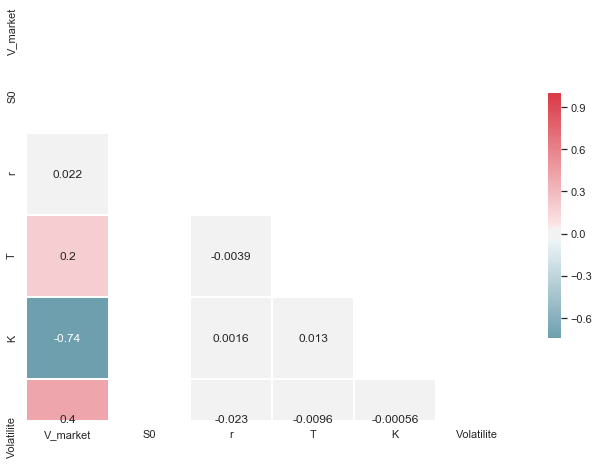

In [33]:
sns.set(style="white")
# Compute the correlation matrix
corr = data.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

In [34]:
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

# Splitting data

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)


# Linear Regression 

                            OLS Regression Results                            
Dep. Variable:             Volatilite   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     1653.
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        02:19:41   Log-Likelihood:                 939.33
No. Observations:               10000   AIC:                            -1869.
Df Residuals:                    9995   BIC:                            -1833.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
V_market       2.2493      0.028     81.254      0.0

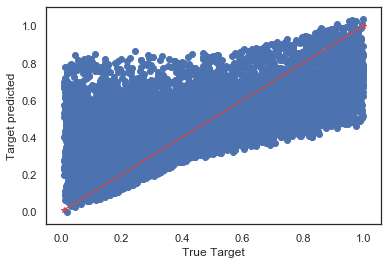

In [36]:
X_ols = sm.add_constant(X)
model = sm.OLS(Y, X_ols)
results = model.fit()
print(results.summary())
Ypred = results.predict(X_ols)
fig,ax1=plt.subplots()
ax1.scatter(Y, Ypred)
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.plot([Y_test.min(),Y_test.max()],[Y_test.min(),Y_test.max()],'r*-')

# Ridge Regression

{'alpha': 0.01}
0.3960365036747892
R2 score 0.40220676314273185


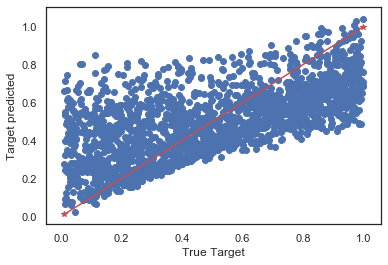

In [37]:
ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor=GridSearchCV(ridge,parameters,cv=10)
ridge_regressor.fit(X_train,Y_train)
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)
Y_pred_ridge = ridge_regressor.predict(X_test)
fig,ax1=plt.subplots()
ax1.scatter(Y_test, Y_pred_ridge)
ax1.plot([Y_test.min(),Y_test.max()],[Y_test.min(),Y_test.max()],'r*-')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
print("R2 score",ridge_regressor.score(X_test,Y_test))


# Lasso Regression

{'alpha': 1e-08}
-0.048378037696916024
R2 score -0.049337333932464505


Text(0.5, 0, 'True Target')

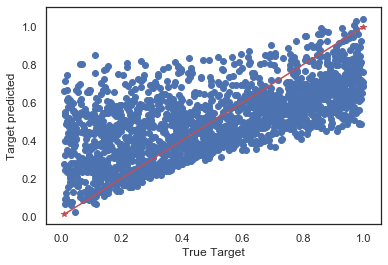

In [38]:
lasso= Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
lasso_regressor=GridSearchCV(lasso,parameters,scoring="neg_mean_squared_error",cv=50)
lasso_regressor.fit(X_train,Y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)
print("R2 score",lasso_regressor.score(X_test,Y_test))
Y_pred_lasso = lasso_regressor.predict(X_test)
fig,ax1=plt.subplots()
ax1.scatter(Y_test, Y_pred_lasso)
ax1.plot([Y_test.min(),Y_test.max()],[Y_test.min(),Y_test.max()],'r*-')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')

# Multivariate Polynomial regression

test r2 score:  0.8856257602598163
mean_squared_error: tf.Tensor(0.009112492473571205, shape=(), dtype=float64)


Text(0.5, 1.0, 'Multivariate Polynomial regression Regression (degree 4)')

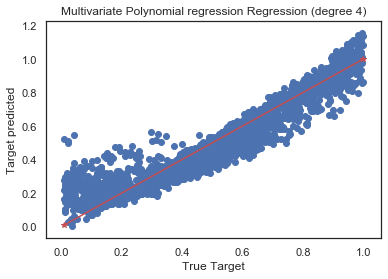

In [39]:

poly = PolynomialFeatures(degree=4)
poly_variables = poly.fit_transform(X)
poly_var_train, poly_var_test, Y_train, Y_test = train_test_split(poly_variables,Y, test_size=0.2)
regression = linear_model.LinearRegression()
model = regression.fit(poly_var_train, Y_train)
score = model.score(poly_var_test, Y_test)
Ypred = regression.predict(poly_var_test)
print('test r2 score: ', r2_score( Y_test, Ypred))
print('mean_squared_error:',mean_squared_error(Y_test,Ypred))
fig,ax=plt.subplots()
ax.scatter(Y_test, Ypred)
ax.plot([Y_test.min(),Y_test.max()],[Y_test.min(),Y_test.max()],'r*-')
ax.set_ylabel('Target predicted')
ax.set_xlabel('True Target')
ax.set_title('Multivariate Polynomial regression Regression (degree 4)')


# KNN

test r2 score:  -0.06643790185481113


Text(0.5, 0, 'True Target')

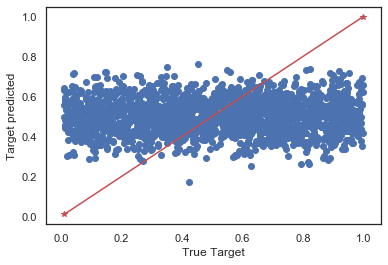

In [40]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train1 = scaler.transform(X_train)
X_test1 = scaler.transform(X_test)
Knn = KNeighborsClassifier(n_neighbors=5)
lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(Y_train)
Knn.fit(X_train1, encoded)
y_pred = Knn.predict(X_test1)
from sklearn.neighbors import KNeighborsRegressor
clf=KNeighborsRegressor(11)
clf.fit(X_train,Y_train)
y_pred=clf.predict(X_test)
print('test r2 score: ', r2_score( Y_test, y_pred))
fig,ax=plt.subplots()
ax.scatter(Y_test, y_pred)
ax.plot([Y_test.min(),Y_test.max()],[Y_test.min(),Y_test.max()],'r*-')
ax.set_ylabel('Target predicted')
ax.set_xlabel('True Target')


# ANN

## Create the Neural Network

In [42]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

def yinversetransform(y):
    return scale.inverse_transform(y)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

file_name = "BS_data"
data = pd.read_excel("../PRR/" + file_name + ".xlsx")

x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

# Cross-Validate
kf = KFold(5, shuffle=True) # Use for KFold classification
    
oos_y = []
oos_pred = []

fold = 0
for train, test in kf.split(x):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    scale2=  StandardScaler()
    scale = StandardScaler()
    x_train_transform = scale2.fit_transform(x[train])
    x_test_transform = scale2.transform(x[test])

    y_train_transform = scale.fit_transform(y[train].reshape(-1, 1))
    y_test_transform = scale.transform(y[test].reshape(-1, 1))
        
    input1 = keras.layers.Input(shape=(5,))
    x1 = keras.layers.Dense(30,activation = 'relu', kernel_initializer="glorot_uniform")(input1)
    x2=keras.layers.Dense(30,activation = 'relu')(x1) 
    x3=keras.layers.Dense(30,activation = 'relu')(x2) 
    x4=keras.layers.Dense(88,activation = 'linear')(x3)

    model = keras.models.Model(inputs=input1, outputs=x4)

    modelGEN.compile(loss =root_mean_squared_error, optimizer = "adam")

    modelGEN.fit(x_train_transform, y_train_transform, batch_size=32, 
             validation_data = (x_test_transform, y_test_transform),epochs = 400, verbose = False,shuffle=1)

    
    pred = yinversetransform(modelGEN.predict(x_test_transform))[:,0]
    Y_true=yinversetransform(y_test_transform)


    oos_y.append(Y_true)
    oos_pred.append(pred)    
    
    score = np.sqrt(metrics.mean_squared_error(pred,Y_true))
    print(f"Fold score (RMSE): {score}")
    print(f"Fold  R2: {r2_score(Y_true, pred)}")
    
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print(f"Final, out of sample score (RMSE): {score}")    

file_name = "BS_data"
data = pd.read_excel("../PRR/" + file_name + ".xlsx")

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


scale2=  StandardScaler()
scale = StandardScaler()
x_train_transform = scale2.fit_transform(x_train)
x_test_transform = scale2.transform(x_test)

y_train_transform = scale.fit_transform(y_train.values.reshape(-1, 1))
y_test_transform = scale.transform(y_test.values.reshape(-1, 1))
def ytransform(y_train,y_test):
    return [scale.transform(y_train.values.reshape(-1, 1)),scale.transform(y_test.values.reshape(-1, 1))]

[y_train_transform,y_test_transform]=ytransform(y_train,y_test)

def yinversetransform(y):
    return scale.inverse_transform(y)

input1 = keras.layers.Input(shape=(5,))
x1 = keras.layers.Dense(30,activation = 'relu', kernel_initializer="glorot_uniform")(input1)
x2=keras.layers.Dense(30,activation = 'relu')(x1) 
x3=keras.layers.Dense(30,activation = 'relu')(x2) 
x4=keras.layers.Dense(88,activation = 'linear')(x3)

modelGEN = keras.models.Model(inputs=input1, outputs=x4)
#modelGEN.summary()
def root_mean_squared_error(y_true, y_pred):
        return K.mean(K.square(y_pred - y_true))
    
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
modelGEN.compile(loss =root_mean_squared_error, optimizer = "adam", metrics=[coeff_determination,'mse', 'mae'])

history=modelGEN.fit(x_train_transform, y_train_transform, batch_size=32, 
             validation_data = (x_test_transform, y_test_transform),epochs = 400, verbose = True,shuffle=1)

  
    
   

Fold #1
Fold score (RMSE): 0.06388957739951688
Fold  R2: 0.9480116600717166
Fold #2
Fold score (RMSE): 0.05997588416695303
Fold  R2: 0.9556377442336277
Fold #3
Fold score (RMSE): 0.049856826365640726
Fold  R2: 0.9697782801098493
Fold #4
Fold score (RMSE): 0.055668465561780435
Fold  R2: 0.9625180222793849
Fold #5
Fold score (RMSE): 0.053303177938707244
Fold  R2: 0.9637946692277402
Final, out of sample score (RMSE): 0.056753669050588956
Train on 8000 samples, validate on 2000 samples
Epoch 1/400
8000/8000 [==============================] - 0s 48us/step - loss: 0.5779 - coeff_determination: -51.7477 - mse: 0.5779 - mae: 0.6113 - val_loss: 0.2378 - val_coeff_determination: -21.6033 - val_mse: 0.2378 - val_mae: 0.3755
Epoch 2/400
8000/8000 [==============================] - 0s 27us/step - loss: 0.2025 - coeff_determination: -17.7077 - mse: 0.2025 - mae: 0.3314 - val_loss: 0.1550 - val_coeff_determination: -13.6981 - val_mse: 0.1550 - val_mae: 0.2899
Epoch 3/400
8000/8000 [==================

Epoch 34/400
8000/8000 [==============================] - 0s 29us/step - loss: 0.0626 - coeff_determination: -4.7703 - mse: 0.0626 - mae: 0.1467 - val_loss: 0.0897 - val_coeff_determination: -7.6322 - val_mse: 0.0897 - val_mae: 0.1806
Epoch 35/400
8000/8000 [==============================] - 0s 29us/step - loss: 0.0623 - coeff_determination: -4.7953 - mse: 0.0623 - mae: 0.1474 - val_loss: 0.0569 - val_coeff_determination: -4.4057 - val_mse: 0.0569 - val_mae: 0.1446
Epoch 36/400
8000/8000 [==============================] - 0s 29us/step - loss: 0.0594 - coeff_determination: -4.4393 - mse: 0.0594 - mae: 0.1434 - val_loss: 0.0487 - val_coeff_determination: -3.5651 - val_mse: 0.0487 - val_mae: 0.1269
Epoch 37/400
8000/8000 [==============================] - 0s 29us/step - loss: 0.0577 - coeff_determination: -4.2905 - mse: 0.0577 - mae: 0.1399 - val_loss: 0.0708 - val_coeff_determination: -5.8223 - val_mse: 0.0708 - val_mae: 0.1588
Epoch 38/400
8000/8000 [==============================] - 0s

Epoch 69/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0554 - coeff_determination: -4.1201 - mse: 0.0554 - mae: 0.1340 - val_loss: 0.0512 - val_coeff_determination: -3.8528 - val_mse: 0.0512 - val_mae: 0.1300
Epoch 70/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0565 - coeff_determination: -4.1362 - mse: 0.0565 - mae: 0.1349 - val_loss: 0.0610 - val_coeff_determination: -4.6723 - val_mse: 0.0610 - val_mae: 0.1238
Epoch 71/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0535 - coeff_determination: -3.9485 - mse: 0.0535 - mae: 0.1290 - val_loss: 0.0614 - val_coeff_determination: -4.8441 - val_mse: 0.0614 - val_mae: 0.1386
Epoch 72/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0577 - coeff_determination: -4.2812 - mse: 0.0577 - mae: 0.1364 - val_loss: 0.0473 - val_coeff_determination: -3.4208 - val_mse: 0.0473 - val_mae: 0.1191
Epoch 73/400
8000/8000 [==============================] - 0s

Epoch 104/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0510 - coeff_determination: -3.6511 - mse: 0.0510 - mae: 0.1264 - val_loss: 0.0534 - val_coeff_determination: -3.9784 - val_mse: 0.0534 - val_mae: 0.1163
Epoch 105/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0521 - coeff_determination: -3.7922 - mse: 0.0521 - mae: 0.1264 - val_loss: 0.0396 - val_coeff_determination: -2.7098 - val_mse: 0.0396 - val_mae: 0.1077
Epoch 106/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0497 - coeff_determination: -3.5992 - mse: 0.0497 - mae: 0.1225 - val_loss: 0.0451 - val_coeff_determination: -3.3169 - val_mse: 0.0451 - val_mae: 0.1206
Epoch 107/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0556 - coeff_determination: -4.1959 - mse: 0.0556 - mae: 0.1320 - val_loss: 0.0468 - val_coeff_determination: -3.4037 - val_mse: 0.0468 - val_mae: 0.1250
Epoch 108/400
8000/8000 [==============================]

Epoch 139/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0512 - coeff_determination: -3.7249 - mse: 0.0512 - mae: 0.1261 - val_loss: 0.0463 - val_coeff_determination: -3.3855 - val_mse: 0.0463 - val_mae: 0.1304
Epoch 140/400
8000/8000 [==============================] - 0s 31us/step - loss: 0.0487 - coeff_determination: -3.5099 - mse: 0.0487 - mae: 0.1231 - val_loss: 0.0408 - val_coeff_determination: -2.8575 - val_mse: 0.0408 - val_mae: 0.1099
Epoch 141/400
8000/8000 [==============================] - 0s 31us/step - loss: 0.0482 - coeff_determination: -3.4150 - mse: 0.0482 - mae: 0.1208 - val_loss: 0.0491 - val_coeff_determination: -3.5695 - val_mse: 0.0491 - val_mae: 0.1135
Epoch 142/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0465 - coeff_determination: -3.2363 - mse: 0.0465 - mae: 0.1191 - val_loss: 0.0400 - val_coeff_determination: -2.7764 - val_mse: 0.0400 - val_mae: 0.1088
Epoch 143/400
8000/8000 [==============================]

Epoch 174/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0462 - coeff_determination: -3.2924 - mse: 0.0462 - mae: 0.1175 - val_loss: 0.0514 - val_coeff_determination: -3.9240 - val_mse: 0.0514 - val_mae: 0.1336
Epoch 175/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0448 - coeff_determination: -3.0988 - mse: 0.0448 - mae: 0.1165 - val_loss: 0.0386 - val_coeff_determination: -2.6485 - val_mse: 0.0386 - val_mae: 0.1051
Epoch 176/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0489 - coeff_determination: -3.4750 - mse: 0.0489 - mae: 0.1213 - val_loss: 0.0451 - val_coeff_determination: -3.2924 - val_mse: 0.0451 - val_mae: 0.1219
Epoch 177/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0483 - coeff_determination: -3.4631 - mse: 0.0483 - mae: 0.1223 - val_loss: 0.0419 - val_coeff_determination: -2.9103 - val_mse: 0.0419 - val_mae: 0.1095
Epoch 178/400
8000/8000 [==============================]

Epoch 209/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0513 - coeff_determination: -3.7664 - mse: 0.0513 - mae: 0.1235 - val_loss: 0.0528 - val_coeff_determination: -3.9916 - val_mse: 0.0528 - val_mae: 0.1256
Epoch 210/400
8000/8000 [==============================] - 0s 31us/step - loss: 0.0482 - coeff_determination: -3.4594 - mse: 0.0482 - mae: 0.1215 - val_loss: 0.0489 - val_coeff_determination: -3.6918 - val_mse: 0.0489 - val_mae: 0.1264
Epoch 211/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0456 - coeff_determination: -3.2516 - mse: 0.0456 - mae: 0.1176 - val_loss: 0.0426 - val_coeff_determination: -3.0566 - val_mse: 0.0426 - val_mae: 0.1099
Epoch 212/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0434 - coeff_determination: -2.9920 - mse: 0.0434 - mae: 0.1135 - val_loss: 0.0458 - val_coeff_determination: -3.2728 - val_mse: 0.0458 - val_mae: 0.1087
Epoch 213/400
8000/8000 [==============================]

Epoch 244/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0452 - coeff_determination: -3.1675 - mse: 0.0452 - mae: 0.1145 - val_loss: 0.0633 - val_coeff_determination: -5.0876 - val_mse: 0.0633 - val_mae: 0.1387
Epoch 245/400
8000/8000 [==============================] - 0s 31us/step - loss: 0.0460 - coeff_determination: -3.2864 - mse: 0.0460 - mae: 0.1162 - val_loss: 0.0595 - val_coeff_determination: -4.6964 - val_mse: 0.0595 - val_mae: 0.1328
Epoch 246/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0455 - coeff_determination: -3.2452 - mse: 0.0455 - mae: 0.1148 - val_loss: 0.0370 - val_coeff_determination: -2.5110 - val_mse: 0.0370 - val_mae: 0.1030
Epoch 247/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0432 - coeff_determination: -3.0113 - mse: 0.0432 - mae: 0.1122 - val_loss: 0.0455 - val_coeff_determination: -3.3324 - val_mse: 0.0455 - val_mae: 0.1153
Epoch 248/400
8000/8000 [==============================]

Epoch 279/400
8000/8000 [==============================] - 0s 29us/step - loss: 0.0449 - coeff_determination: -3.1202 - mse: 0.0449 - mae: 0.1153 - val_loss: 0.0374 - val_coeff_determination: -2.5483 - val_mse: 0.0374 - val_mae: 0.1023
Epoch 280/400
8000/8000 [==============================] - 0s 29us/step - loss: 0.0442 - coeff_determination: -3.0510 - mse: 0.0442 - mae: 0.1153 - val_loss: 0.0374 - val_coeff_determination: -2.5607 - val_mse: 0.0374 - val_mae: 0.1021
Epoch 281/400
8000/8000 [==============================] - 0s 29us/step - loss: 0.0483 - coeff_determination: -3.4708 - mse: 0.0483 - mae: 0.1227 - val_loss: 0.0382 - val_coeff_determination: -2.5731 - val_mse: 0.0382 - val_mae: 0.1004
Epoch 282/400
8000/8000 [==============================] - 0s 29us/step - loss: 0.0455 - coeff_determination: -3.1916 - mse: 0.0455 - mae: 0.1148 - val_loss: 0.0476 - val_coeff_determination: -3.5751 - val_mse: 0.0476 - val_mae: 0.1171
Epoch 283/400
8000/8000 [==============================]

Epoch 314/400
8000/8000 [==============================] - 0s 28us/step - loss: 0.0434 - coeff_determination: -2.9827 - mse: 0.0434 - mae: 0.1104 - val_loss: 0.0478 - val_coeff_determination: -3.4950 - val_mse: 0.0478 - val_mae: 0.1229
Epoch 315/400
8000/8000 [==============================] - 0s 28us/step - loss: 0.0466 - coeff_determination: -3.3106 - mse: 0.0466 - mae: 0.1170 - val_loss: 0.0533 - val_coeff_determination: -4.1075 - val_mse: 0.0533 - val_mae: 0.1250
Epoch 316/400
8000/8000 [==============================] - 0s 28us/step - loss: 0.0453 - coeff_determination: -3.1783 - mse: 0.0453 - mae: 0.1142 - val_loss: 0.0491 - val_coeff_determination: -3.5706 - val_mse: 0.0491 - val_mae: 0.1198
Epoch 317/400
8000/8000 [==============================] - 0s 28us/step - loss: 0.0446 - coeff_determination: -3.1601 - mse: 0.0446 - mae: 0.1174 - val_loss: 0.0407 - val_coeff_determination: -2.8443 - val_mse: 0.0407 - val_mae: 0.1139
Epoch 318/400
8000/8000 [==============================]

Epoch 349/400
8000/8000 [==============================] - 0s 29us/step - loss: 0.0409 - coeff_determination: -2.8025 - mse: 0.0409 - mae: 0.1093 - val_loss: 0.0374 - val_coeff_determination: -2.5461 - val_mse: 0.0374 - val_mae: 0.0996
Epoch 350/400
8000/8000 [==============================] - 0s 29us/step - loss: 0.0402 - coeff_determination: -2.6687 - mse: 0.0402 - mae: 0.1067 - val_loss: 0.0352 - val_coeff_determination: -2.2874 - val_mse: 0.0352 - val_mae: 0.0995
Epoch 351/400
8000/8000 [==============================] - 0s 29us/step - loss: 0.0441 - coeff_determination: -3.0537 - mse: 0.0441 - mae: 0.1140 - val_loss: 0.0396 - val_coeff_determination: -2.7103 - val_mse: 0.0396 - val_mae: 0.1101
Epoch 352/400
8000/8000 [==============================] - 0s 29us/step - loss: 0.0439 - coeff_determination: -3.0442 - mse: 0.0439 - mae: 0.1111 - val_loss: 0.0470 - val_coeff_determination: -3.3743 - val_mse: 0.0470 - val_mae: 0.1003
Epoch 353/400
8000/8000 [==============================]

Epoch 384/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0390 - coeff_determination: -2.6413 - mse: 0.0390 - mae: 0.1046 - val_loss: 0.0435 - val_coeff_determination: -3.1278 - val_mse: 0.0435 - val_mae: 0.1125
Epoch 385/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0430 - coeff_determination: -2.9767 - mse: 0.0430 - mae: 0.1107 - val_loss: 0.0590 - val_coeff_determination: -4.5053 - val_mse: 0.0590 - val_mae: 0.1119
Epoch 386/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0399 - coeff_determination: -2.6631 - mse: 0.0399 - mae: 0.1054 - val_loss: 0.0362 - val_coeff_determination: -2.4390 - val_mse: 0.0362 - val_mae: 0.1024
Epoch 387/400
8000/8000 [==============================] - 0s 30us/step - loss: 0.0468 - coeff_determination: -3.2933 - mse: 0.0468 - mae: 0.1182 - val_loss: 0.0397 - val_coeff_determination: -2.7354 - val_mse: 0.0397 - val_mae: 0.0998
Epoch 388/400
8000/8000 [==============================]

# plotting the loss ( RMSE) of the training and testing data

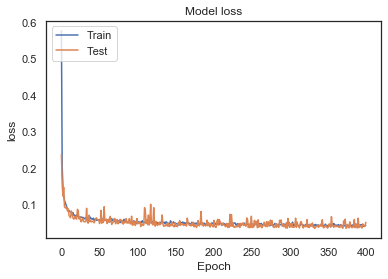

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plotting the log (MSE) of the training and testing data

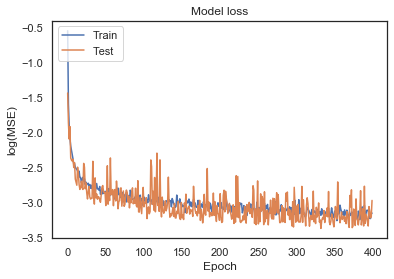

In [50]:
import matplotlib.pyplot as plt
plt.plot(np.log(history.history['mse']))
plt.plot(np.log(history.history['val_mse']))
plt.title('Model loss')
plt.ylabel('log(MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Computation of the R^2 score of the model 

In [44]:
predictions = yinversetransform(modelGEN.predict(x_test_transform))[:,0]
Y_true=yinversetransform(y_test_transform)
r2_score(Y_true, predictions)

0.9473373322396869

# plot of the predicition made by the NN accoridng to the true values of implied volatility

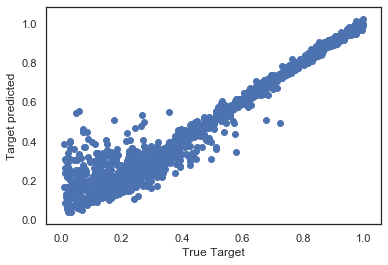

In [47]:
ax = plt.subplot(111)
ax.scatter(Y_true, predictions)
#ax1.plot([Y_true.min(),Y_true.max()],[Y_true.min(),Y_true.max()],'r*-')
ax.set_ylabel('Target predicted')
ax.set_xlabel('True Target')
ax1.plot([Y_test.min(),Y_test.max()],[Y_test.min(),Y_test.max()],'r*-')

# plot of the smiles 

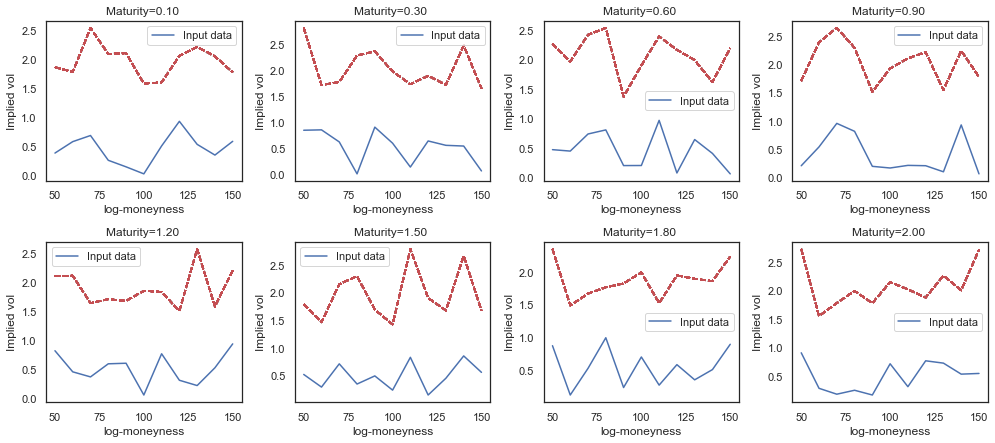

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import scipy
S0=1.
strikes=np.array([50,60,70,80,90,100,110,120,130,140,150 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
##### AVERAGE VALUES #######
X_sample = (x_test_transform)
y_sample = y_test_transform

X_sample = X_test
y_sample = y_test_transform


prediction=modelGEN.predict(x_test)
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(strikes,y_test[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(strikes,prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',)

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()